# Hyperparameter Tuning

Scikit-learn documentation:
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)
* [Breast Cancer dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/murilogustineli/hype-tuning/blob/main/gridsearch.ipynb)

### Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load sklearn libraries
from sklearn import tree
from sklearn.datasets import load_breast_cancer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import (
    train_test_split, learning_curve, validation_curve,
    StratifiedKFold, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    make_scorer, classification_report)

### Helper functions

In [2]:
# Rename columns to lower case
def rename_columns(df: pd.DataFrame, ) -> pd.DataFrame:
    # Rename columns to lower case
    cols = list(df.columns)
    lower_cols = [col.replace(" ", "_").lower() for col in cols]
    df.columns = lower_cols
    return df


# Load breast cancer dataset from sklearn
def load_breast_cancer_data():
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)
    # Rename columns
    X = rename_columns(df=X)
    return X, y


# Preprocess data
def preprocess_data(load_data, test_size=0.2, oversample=False):
    # Load dataset
    X, y = load_data

    # Train/Test Split using Stratified Sampling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    # Oversampling using SMOTE
    if oversample:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test


def plot_scales(df, feature1, feature2):
    fig, ax = plt.subplots(figsize=(6, 4), dpi=150)
    ax.scatter(df[feature1], df[feature2])
    ax.set_title('Different scales between two features')
    ax.set_xlabel(f"{feature1.replace('_', ' ').title()}")
    ax.set_ylabel(f"{feature2.replace('_', ' ').title()}")
    ax.grid(color='blue', linestyle='--', linewidth=1, alpha=0.2)
    ax.spines[['top', 'right']].set_visible(False)
    fig.tight_layout(pad=3)

## Part 1: Machine Learning intro

### Load data from sklearn

In [3]:
from sklearn.datasets import load_breast_cancer

# Load Breast Cancer dataset from sklearn
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

# Data dimensions
X.shape, y.shape

((569, 30), (569,))

In [4]:
# Distribution of target variable
y.value_counts()

1    357
0    212
Name: target, dtype: int64

Dataset summary:
1. The Breast Cancer dataset has 569 instances and 31 features
    * Each instance has a binary target variable indicating the patient’s diagnosis (malignant or benign)
    * `Malignant` == 0
    * `Benign` == 1
2. The target class distribution is **imbalanced!**
    * 357 instances diagnosed as benign and 212 as malignant.

### Training a model

In [5]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
clf = KNeighborsClassifier()


# Fit model
clf.fit(X, y)
# Make predictions
y_pred = clf.predict(X)
# Scores
score = clf.score(X, y)
f1 = f1_score(y_pred, y)

# Scores
print(f"{clf.__class__.__name__}")
print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

KNeighborsClassifier
Accuracy: 0.947
F1 Score: 0.959


In [6]:
# DecisionTreeClassifier object
clf

KNeighborsClassifier()

In [7]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

# DecisionTree
clf = DecisionTreeClassifier(max_depth=2)

# Fit model
clf.fit(X, y)
# Make predictions
y_pred = clf.predict(X)
# Scores
score = clf.score(X, y)
f1 = f1_score(y_pred, y)

# Scores
print(f"{clf.__class__.__name__}")
print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

DecisionTreeClassifier
Accuracy: 0.942
F1 Score: 0.953


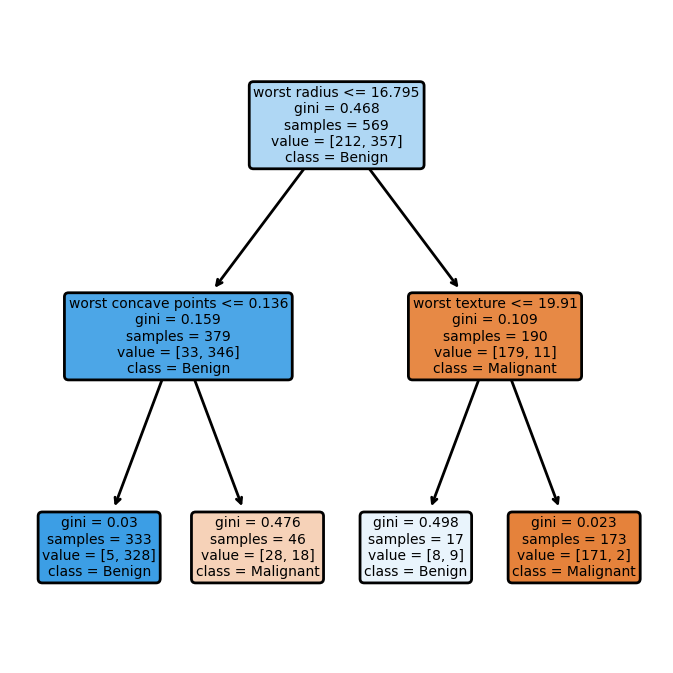

In [8]:
# Visualize Decision Tree
feature_names = list(X.columns)
class_names = ['Malignant', 'Benign'] # Malignant==0, Benign==1

# Init plot
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=200)
tree.plot_tree(
    clf,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    fontsize=5,
    rounded=True);
fig.tight_layout(pad=3);

## Part 2: Pipelines

### Scaling features
`Scaling` features is important because it can help improve the performance of the model.
1. Scaling ensures that each feature is on a similar scale.
2. Prevents some features from dominating others in terms of their influence on teh model.
3. Help convergence of certain algorithms.
4. Make the model more robust to outliers and noise in the data.

In [9]:
# Rename columns to lower case
cols = list(X.columns)
lower_cols = [col.replace(" ", "_").lower() for col in cols]
X.columns = lower_cols

In [10]:
# Get max from each feature
mean_radius_max = np.max(X['mean_area'])
mean_area_max = np.max(X['mean_smoothness'])

print(f'Max mean area:   {mean_radius_max}')
print(f'Max mean smooth: {mean_area_max}')

Max mean area:   2501.0
Max mean smooth: 0.1634


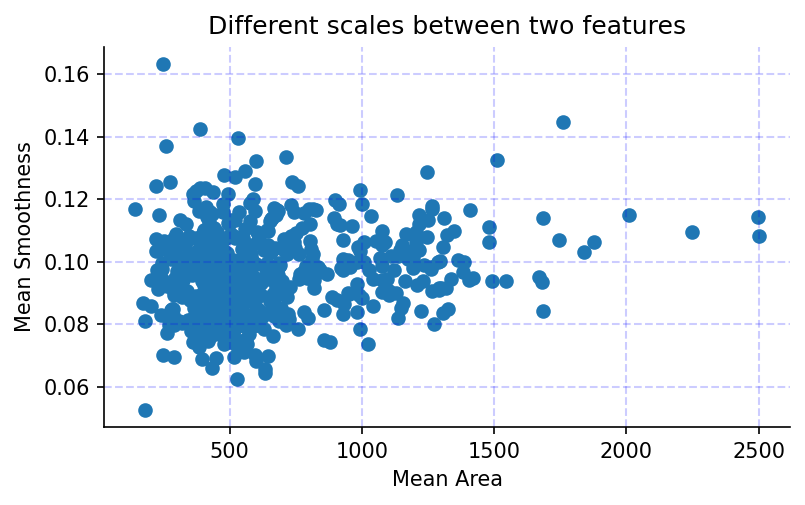

In [11]:
# Plot difference
plot_scales(df=X, feature1='mean_area', feature2='mean_smoothness')

### StandardScaler

In [12]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

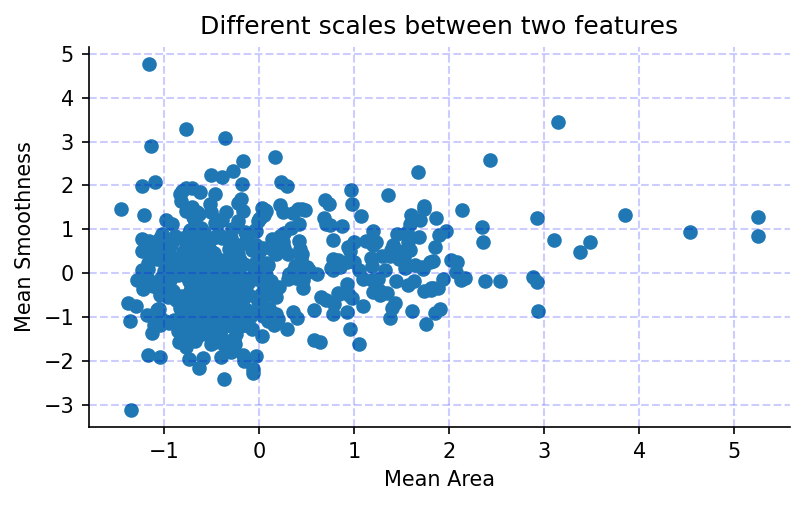

In [13]:
# Plot difference
plot_scales(df=X_scaled, feature1='mean_area', feature2='mean_smoothness')

### We have to rethink what our model actually is!

### Creating your first pipeline
Let's put everything into a pipeline!

### KNN pipeline

In [14]:
from sklearn.pipeline import Pipeline

# KNN pipeline
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())])

# Fit model
pipe.fit(X, y)
# Make predictions
y_pred = pipe.predict(X)
# Scores
score = pipe.score(X, y)
f1 = f1_score(y_pred, y)

# Scores
print(f"{pipe['model'].__class__.__name__}")
print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

KNeighborsClassifier
Accuracy: 0.981
F1 Score: 0.985


In [15]:
# Pipeline object
pipe

Pipeline(steps=[('scale', StandardScaler()), ('model', KNeighborsClassifier())])

In [16]:
# Pipeline scaler
pipe['scale']

StandardScaler()

In [17]:
# Pipeline model
pipe['model']

KNeighborsClassifier()

### DecisionTree pipeline

In [18]:
# Decision Tree pipeline
pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier(max_depth=2))])

# Fit model
pipe.fit(X, y)
# Make predictions
y_pred = pipe.predict(X)
# Scores
score = pipe.score(X, y)
f1 = f1_score(y_pred, y)

print(f"Accuracy: {round(score, 3)}")
print(f"F1 Score: {round(f1, 3)}")

Accuracy: 0.942
F1 Score: 0.953


In [19]:
# Pipeline object
pipe

Pipeline(steps=[('scale', StandardScaler()),
                ('model', DecisionTreeClassifier(max_depth=2))])

### Run different pipelines

In [49]:
# Function to run pipelines
def fit_predict(pipe: object, X: pd.DataFrame,  y: pd.DataFrame):
    # Fit model
    pipe.fit(X, y)
    # Make predictions
    y_pred = pipe.predict(X)
    # Scores
    score = pipe.score(X, y)
    f1 = f1_score(y_pred, y)
    
    print(f"{str(pipe['model'].__class__.__name__)}")
    print(f"Accuracy: {round(score, 3)}")
    print(f"F1 Score: {round(f1, 3)}\n")

In [50]:
# KNN pipeline
knn_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=5))])

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier(max_depth=2))])

# Fit pipelines
fit_predict(pipe=knn_pipe, X=X, y=y)
fit_predict(pipe=dt_pipe, X=X, y=y)

KNeighborsClassifier
Accuracy: 0.981
F1 Score: 0.985

DecisionTreeClassifier
Accuracy: 0.942
F1 Score: 0.953



### We're making a HUGE mistake!!!
How do we know we are able to **generalize** to new data?
* We used the entire data for training and testing, and that's bad!!
* We don't want to evaluate model performance on the same dataset we used to train it.
    * **Generalization** is about the ability of a model to perform well on unseen data.
* We need to split the data intro `training` and `testing`.
    * Use the `training` data to fit the model and make predictions
    * Use the `testing` data to test the model performance

### Train/Test split

In [45]:
# Train/Test Split using Stratified Sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

Train data: ((455, 30), (455,))
Test data:  ((114, 30), (114,))


### Handle imbalanced data
The data is also imbalanced, where one class have more instances than another class.
* 357 instances diagnosed as `benign` and 212 as `malignant`.

In [46]:
# SMOTE (Synthetic Minority Oversampling Technique)
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

Train data: ((570, 30), (570,))
Test data:  ((114, 30), (114,))


In [47]:
# Class distribution after SMOTE
y_train.value_counts()

1    285
0    285
Name: target, dtype: int64

In [48]:
# Test data class distribution
y_test.value_counts()

1    72
0    42
Name: target, dtype: int64

### Preprocess data
Putting all the steps above together

In [33]:
# Preprocess data
def preprocess_data(test_size=0.2, oversample=False) -> tuple:
    # Load dataset
    X, y = load_breast_cancer(return_X_y=True, as_frame=True)

    # Train/Test Split using Stratified Sampling
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42)

    # Oversampling using SMOTE
    if oversample:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [34]:
# Get data
X_train, X_test, y_train, y_test = preprocess_data(test_size=0.2, oversample=True)

print(f"Train data: {X_train.shape, y_train.shape}")
print(f"Test data:  {X_test.shape, y_test.shape}")

Train data: ((570, 30), (570,))
Test data:  ((114, 30), (114,))


In [35]:
# KNN pipeline
knn_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', KNeighborsClassifier())])

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier(max_depth=1))])

# Fit pipelines
fit_predict(pipe=knn_pipe)
fit_predict(pipe=dt_pipe)

KNeighborsClassifier
Accuracy: 0.981
F1 Score: 0.985

DecisionTreeClassifier
Accuracy: 0.923
F1 Score: 0.94



## Part 3: GridSearch

* `GridSearch` is a technique used to find the optimal hyperparameters for a machine learning model.
* `Hyperparameters` are parameters that are set before training the model and cannot be learned from the data.
* `Hyperparameter tuning` is the process of finding the best hyperparameters for a given machine learning algorithm and dataset.
    * The performance of a machine learning model is highly dependent on the values of its hyperparameters.
    * Choosing the right hyperparameters is critical for achieving good performance.
* `Stratified Sampling` ensures the population is divided into homogeneous subgroups where the right amount of instances is sampled from each class
    * Guarantees that the test set is representative of the overall population

**Scikit-learn documentation:**
* [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
* [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
* [`KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [40]:
# Looking at DecisionTree parameters
dt_pipe['model'].get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 1,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [57]:
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Decision Tree pipeline
dt_pipe = Pipeline(steps=[
    ('scale', StandardScaler()),
    ('model', DecisionTreeClassifier())])

# GridSearchCV params
dt_param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': list(range(1, 11, 1)),
    'model__min_samples_leaf': list(range(1, 11, 1))}

# Stratified sampling
strat_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Init GridSearchCV
gridsearch = GridSearchCV(
    estimator=dt_pipe,
    param_grid=dt_param_grid,
    scoring='f1',
    cv=strat_kfold,
    verbose=2,
    n_jobs=-1)

In [68]:
# Fit model
dt_clf = gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


#### Why 200 candidates? Why 1,000 fits?

In [61]:
criterion = ['gini', 'entropy']
max_depth = list(range(1, 11, 1))
min_samples_leaf = list(range(1, 11, 1))
n_splits = 5

candidates = len(criterion) * len(max_depth) * len(min_samples_leaf)
print(f'Candidates: {candidates}')
print(f'Total fits: {candidates*n_splits}')

Candidates: 200
Total fits: 1000


In [71]:
# Look at GridSearch object
dt_clf

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'model__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                     10]},
             scoring='f1', verbose=2)

In [67]:
# Best estimator
dt_clf.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 DecisionTreeClassifier(max_depth=8, min_samples_leaf=3))])

In [74]:
# Best parameters
dt_clf.best_params_

{'model__criterion': 'gini',
 'model__max_depth': 6,
 'model__min_samples_leaf': 5}

### Make predictions

In [81]:
# Train and test scores
train_score = dt_clf.score(X_train, y_train)
test_score = dt_clf.score(X_test, y_test)

print(f'Train score: {round(train_score, 3)}')
print(f'Test score:  {round(test_score, 3)}')

Train score: 0.991
Test score:  0.944


In [83]:
# F1 score
y_pred = dt_clf.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1 score: {round(f1, 3)}')

F1 score: 0.944


### Performance metrics

In [84]:
# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Display scores
print(f'{dt_clf.__class__.__name__}')
print(f"Train score:     {round(train_score, 3)}")
print(f"Test score:      {round(test_score, 3)}")
print(f"Accuracy score:  {round(accuracy, 3)}")
print(f"Precision score: {round(precision, 3)}")
print(f"Recall score:    {round(recall, 3)}")
print(f"F1 score:        {round(f1, 3)}")
print(f"ROC AUC score:   {round(roc_auc, 3)}")

GridSearchCV
Train score:     0.991
Test score:      0.944
Accuracy score:  0.93
Precision score: 0.957
Recall score:    0.931
F1 score:        0.944
ROC AUC score:   0.93


In [73]:
# Look at GridSearchCV results
df = pd.DataFrame(gridsearch.cv_results_)
df.head(15)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.013164      0.001717         0.008378        0.004829   
1        0.014563      0.001352         0.023536        0.024823   
2        0.034309      0.027105         0.006182        0.001467   
3        0.011370      0.001492         0.005187        0.000403   
4        0.012966      0.002522         0.008777        0.007148   
5        0.011768      0.001466         0.005386        0.000800   
6        0.012166      0.001935         0.005588        0.000491   
7        0.017752      0.006476         0.006982        0.002523   
8        0.012965      0.001786         0.005585        0.000490   
9        0.013962      0.002821         0.005385        0.000798   
10       0.013965      0.001260         0.005784        0.000746   
11       0.014960      0.001785         0.006581        0.003254   
12       0.013964      0.002184         0.004786        0.000401   
13       0.020744      0.006775         0.005585        0.000799   
14       0.018547      0.009763         0.007181        0.002631   

   param_model__criterion param_model__max_depth  \
0                    gini                      1   
1                    gini                      1   
2                    gini                      1   
3                    gini                      1   
4                    gini                      1   
5                    gini                      1   
6                    gini                      1   
7                    gini                      1   
8                    gini                      1   
9                    gini                      1   
10                   gini                      2   
11                   gini                      2   
12                   gini                      2   
13                   gini                      2   
14                   gini                      2   

   param_model__min_samples_leaf  \
0                              1   
1                              2   
2                              3   
3                              4   
4                              5   
5                              6   
6                              7   
7                              8   
8                              9   
9                             10   
10                             1   
11                             2   
12                             3   
13                             4   
14                             5   

                                               params  split0_test_score  \
0   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
1   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
2   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
3   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
4   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
5   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
6   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
7   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
8   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
9   {'model__criterion': 'gini', 'model__max_depth...           0.907407   
10  {'model__criterion': 'gini', 'model__max_depth...           0.939130   
11  {'model__criterion': 'gini', 'model__max_depth...           0.939130   
12  {'model__criterion': 'gini', 'model__max_depth...           0.939130   
13  {'model__criterion': 'gini', 'model__max_depth...           0.939130   
14  {'model__criterion': 'gini', 'model__max_depth...           0.939130   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.935780           0.859813           0.894737   
1            0.935780           0.859813           0.894737   
2            0.935780           0.859813           0.894737   
3            0.935780           0.85